#### library

In [203]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine, Unit
import sys
from datetime import datetime, timedelta
from geopy.distance import great_circle

from sklearn.neighbors import KDTree, BallTree
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor, GradientBoostingRegressor
import optuna
import catboost as cb

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

utils_directory = os.path.abspath('..')
sys.path.append(utils_directory)

import preprocessing

from utils.constant_utils import Directory
from utils import common_utils

import model
from inference import *

features_directory = os.path.abspath('../features')
sys.path.append(features_directory)

from clustering_features import *
from count_features import *
from distance_features import *
from other_features import *

#### data load

In [204]:
print("Start the main.py successfully!")

'''
name : 실험자 이름입니다.
title : result 폴더에 저장될 실험명을 지정합니다.
'''
name = 'eun'
title = 'cluster,timefeature,categorical,drop,gangnam,xgb1000'

print("total data load ...")
df = common_utils.merge_data(Directory.train_data, Directory.test_data)
df = preprocessing.handle_age_outliers(df)
print(df.shape)
df_train = df[df['type'] == 'train']
df_train = preprocessing.handle_duplicates(df_train)
df_test = df[df['type'] == 'test']

df = pd.concat([df_train, df_test])

Start the main.py successfully!
total data load ...


(1947949, 12)


#### feature 생성

In [205]:
total_df = df.copy()

In [206]:
# 동일한 아파트(위도, 경도, 건축연도, 면적)의 최근 전세가
def add_recent_rent_in_building(total_df):
    total_df['contract_date'] = total_df['contract_year_month'] * 100 + total_df['contract_day']
    
    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    df_train_sorted = df_train.sort_values(by=['latitude', 'longitude', 'built_year', 'area_m2', 'contract_date'])
    
    df_train_sorted['recent_rent_in_building'] = df_train_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['deposit'].shift(1)
    df_train_sorted['recent_rent_in_building'].fillna(df_train_sorted['deposit'], inplace=True)
    
    recent_rent_index = df_train_sorted.groupby(['latitude', 'longitude', 'built_year', 'area_m2'])['recent_rent_in_building'].nth(-1).index
    recent_rent_df = df_train_sorted.loc[recent_rent_index]
    
    df_test_merged = df_test.merge(recent_rent_df[['latitude','longitude','built_year','area_m2','recent_rent_in_building']], on=['latitude','longitude','built_year','area_m2'], how='left').set_index(df_test.index)
    df_test_merged.fillna(0, inplace=True)
    
    total_df = pd.concat([df_train_sorted.sort_index(),df_test_merged])
    
    return total_df

In [207]:
# 해당 지역(위도, 경도)의 과거 평균 전세가
def add_avg_rent_in_past_year(total_df):

    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()
    
    df_train['avg_rent_in_past_year'] = df_train.groupby(['latitude', 'longitude', 'built_year'])['deposit'].transform('median').round(0)
    avg_rent_map = df_train.groupby(['latitude', 'longitude', 'built_year'])['avg_rent_in_past_year'].last().reset_index()
    df_test = df_test.merge(avg_rent_map, on=['latitude', 'longitude', 'built_year'], how='left')
        
    df_train['avg_rent_in_past_year'].fillna(0, inplace=True)
    df_test['avg_rent_in_past_year'].fillna(0, inplace=True)
    
    total_df.loc[total_df['type'] == 'train', 'avg_rent_in_past_year'] = df_train['avg_rent_in_past_year']
    total_df.loc[total_df['type'] == 'test', 'avg_rent_in_past_year'] = df_test['avg_rent_in_past_year']
    
    return total_df

In [208]:
# 연도별 전세가 상승률
def add_rent_growth_rate(total_df):
    total_df['contract_year'] = total_df['contract_year_month'] // 100

    df_train = total_df[total_df['type'] == 'train'].copy()
    df_test = total_df[total_df['type'] == 'test'].copy()

    median_deposit = df_train.groupby(['latitude', 'longitude', 'contract_year'])['deposit'].median().reset_index()
    median_deposit['previous_year_deposit'] = median_deposit.groupby(['latitude', 'longitude'])['deposit'].shift(1)
    median_deposit['deposit_rate'] = ((median_deposit['deposit'] - median_deposit['previous_year_deposit']) / median_deposit['previous_year_deposit']).round(2)

    # 연도별 평균 상승률 계산
    mean_deposit_rate_per_year = median_deposit.groupby('contract_year')['deposit_rate'].transform('mean').round(2)
    median_deposit['deposit_rate'] = median_deposit['deposit_rate'].fillna(mean_deposit_rate_per_year)

    # 전체 평균 상승률 계산
    median_deposit['deposit_rate'] = median_deposit['deposit_rate'].fillna(median_deposit['deposit_rate'].mean().round(2))

    train_index = df_train.index

    df_train_new = df_train.merge(median_deposit[['latitude','longitude','contract_year','deposit_rate']], on = ['latitude','longitude','contract_year'], how='left')
    df_train_new.index = train_index
    recent_data = median_deposit.loc[median_deposit.groupby(['latitude', 'longitude'])['contract_year'].idxmax()]

    original_index = df_test.index
    df_test_new = df_test.merge(recent_data[['latitude', 'longitude', 'deposit_rate']], on=['latitude', 'longitude'], how='left')

    df_test_new.index = original_index
    df_test_new['deposit_rate'] = df_test_new['deposit_rate'].fillna(median_deposit['deposit_rate'].mean().round(2))
    
    df_train_new = df_train_new.drop(columns=['contract_year'])
    df_test_new = df_test_new.drop(columns=['contract_year'])
    
    # 원래 데이터프레임에 업데이트
    total_df = pd.concat([df_train_new.sort_index(), df_test_new.sort_index()])
    
    return total_df

In [209]:
def deposit_fe(df):
    df = add_recent_rent_in_building(total_df)
    df = add_avg_rent_in_past_year(df)
    df = add_rent_growth_rate(df)
    return df

In [211]:
new_df_fe = deposit_fe(total_df)
new_df_fe = new_df_fe.drop(columns = ['contract_date'])
new_df_fe['recent_rent_in_building'].fillna(0, inplace=True)
new_df_fe.head(3)

,area_m2,contract_year_month,contract_day,contract_type,floor,built_year,latitude,longitude,age,deposit,type,interest_rate,recent_rent_in_building,avg_rent_in_past_year,deposit_rate
0,84.9981,201906,25,2,9,2019,37.054314,127.045216,0,17000.0,train,1.78,17000.0,33000.0,0.07
1,84.9981,202003,26,2,20,2019,37.054314,127.045216,1,23000.0,train,1.26,17000.0,33000.0,0.71
2,84.9981,202003,28,2,8,2019,37.054314,127.045216,1,23000.0,train,1.26,23000.0,33000.0,0.71


In [212]:
### 클러스터 피처 apply
print("clustering apply ...")
for info_df_name in ['subway_info', 'school_info', 'park_info']:
    info_df = getattr(Directory, info_df_name)  
    df = clustering(new_df_fe, info_df, feat_name=info_df_name, n_clusters=20)

### 이상치 처리
print("start to cleaning outliers...")
df = preprocessing.handle_age_outliers(df)

### 데이터 분할
print("train, valid, test split for preprocessing & feature engineering ...")
train_data_, valid_data_, test_data_ = common_utils.train_valid_test_split(df)


### 데이터 전처리
print("start to preprocessing...")
# type 카테고리화
train_data_ = preprocessing.numeric_to_categoric(train_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
valid_data_ = preprocessing.numeric_to_categoric(valid_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})
test_data_ = preprocessing.numeric_to_categoric(test_data_, 'contract_type', {0:'new', 1:'renew', 2:'unknown'})

# 중복 제거
train_data_ = preprocessing.handle_duplicates(train_data_)
valid_data_ = preprocessing.handle_duplicates(valid_data_)

# 로그 변환
#df = preprocessing_fn.log_transform(df, 'deposit')


### 피처 엔지니어링
print("start to feature engineering...")
# clustering_feature
print("create clustering features")
train_data, valid_data, test_data = create_clustering_target(train_data_, valid_data_, test_data_)

# distance_features
print("create distance features")
train_data, valid_data, test_data = distance_gangnam(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_school_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = weighted_subway_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_nearest_park_distance_and_area(train_data, valid_data, test_data)

# other_features
print("create other features")
train_data, valid_data, test_data = create_temporal_feature(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sin_cos_season(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_floor_area_interaction(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sum_park_area_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = shift_interest_rate_function(train_data, valid_data, test_data)
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'age')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'floor')
train_data, valid_data, test_data = categorization(train_data, valid_data, test_data, category = 'area_m2')


# count_features
print("create count features")
train_data, valid_data, test_data = transaction_count_function(train_data, valid_data, test_data)
# 위의 함수를 바로 실행하기 위한 구조 : data/transaction_data에 train/valid/test_transaction_{month}.txt 구조의 파일이 있어야함
train_data, valid_data, test_data = create_subway_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_counts_within_radius_by_school_level(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_place_within_radius(train_data, valid_data, test_data)

clustering apply ...
start to cleaning outliers...
train, valid, test split for preprocessing & feature engineering ...
start to preprocessing...
start to feature engineering...
create clustering features
create distance features
create other features
create count features
Loading pre-calculated transaction data for 3 months.


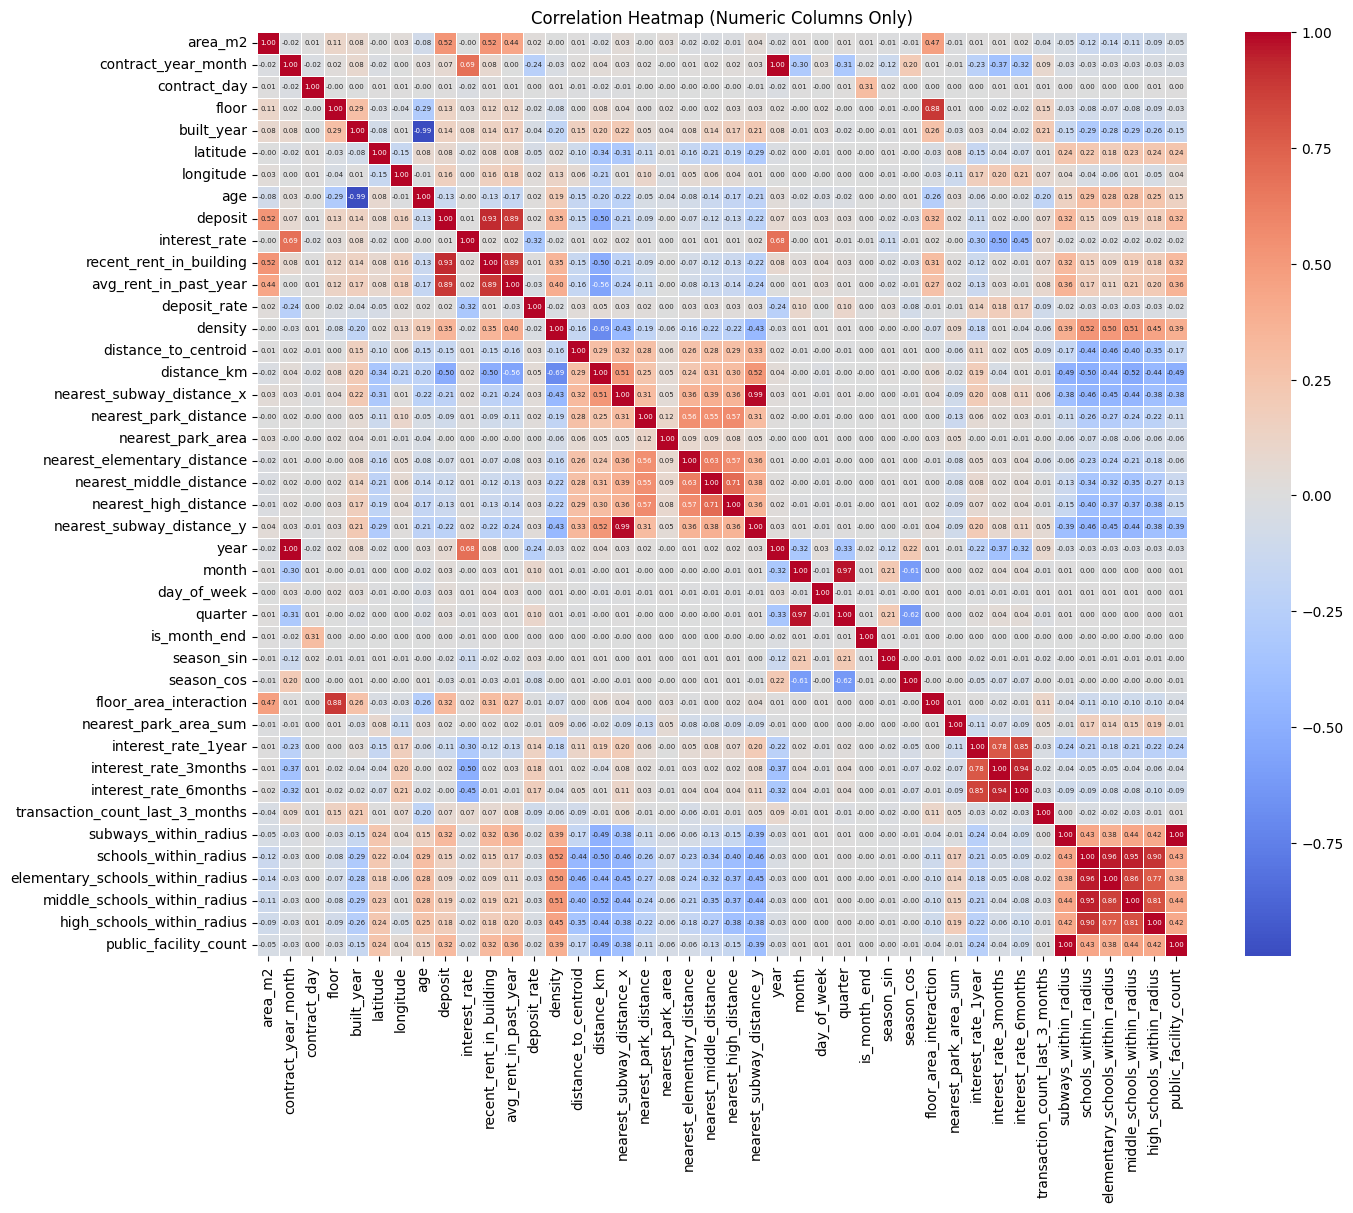

In [242]:
df_numeric = train_data.select_dtypes(include=['float', 'int'])

# 상관관계 계산
corr = df_numeric.corr()

# 시각화
plt.figure(figsize=(15, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5,
            annot_kws={'size': 5})

# 그래프 표시
plt.title('Correlation Heatmap (Numeric Columns Only)')
plt.show()

#### modeling

In [213]:
print("standardization...")
train_data_, valid_data_, test_data_ = preprocessing.standardization(train_data, valid_data, test_data, scaling_type = 'standard')
# feature selection
train_data_scaled, valid_data_scaled, test_data_scaled = preprocessing.feature_selection(train_data_, valid_data_, test_data_)
# feature split
X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled)

standardization...


In [214]:
model_ = model.xgboost(X_train, y_train)

# Feature importance 추출
importance = model_.feature_importances_

# Feature importance를 DataFrame으로 변환
train_df = train_data_.copy()
train_df = train_df.drop(columns = ['deposit'], axis=1)

importance_df = pd.DataFrame({
    'Feature': train_df.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

In [215]:
#### 상위 n개에 대한 데이터만 실험
top_n_features = list(importance_df.head(25)['Feature'].values)
top_n_features

['recent_rent_in_building',
 'avg_rent_in_past_year',
 'built_year',
 'contract_type',
 'contract_year_month',
 'area_m2',
 'distance_km',
 'latitude',
 'deposit_rate',
 'floor_area_interaction',
 'nearest_park_area_sum',
 'nearest_park_area',
 'transaction_count_last_3_months',
 'age_category',
 'longitude',
 'area_category',
 'floor',
 'high_schools_within_radius',
 'nearest_elementary_distance',
 'distance_to_centroid',
 'nearest_subway_distance_x',
 'nearest_park_distance',
 'middle_schools_within_radius',
 'nearest_middle_distance',
 'subways_within_radius']

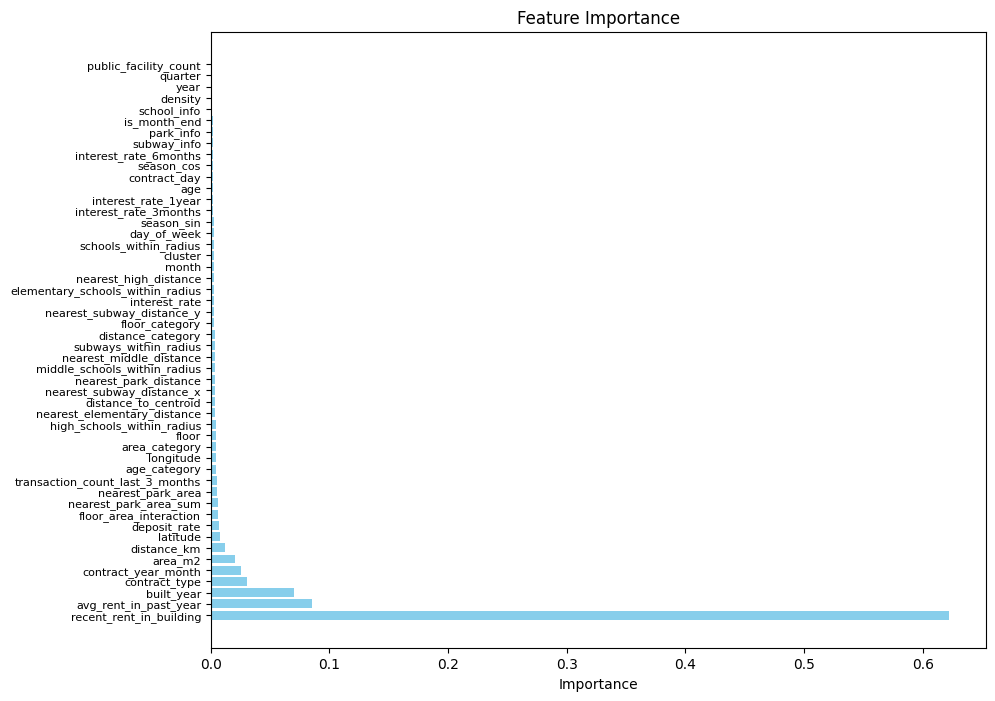

In [216]:
# Feature importance 시각화
plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.yticks(fontsize=8)
plt.title('Feature Importance')
plt.show()

In [235]:
# feature split(test - feature 수를 바꿔가며)
train_data_n = train_data_scaled[top_n_features[0:1] + top_n_features[2:20] + ['deposit']]
valid_data_n = valid_data_scaled[top_n_features[0:1] + top_n_features[2:20] + ['deposit']]
test_data_n = test_data_scaled[top_n_features[0:1] + top_n_features[2:20]]

X_train, y_train, X_valid, y_valid, X_test = common_utils.split_feature_target(train_data_n, valid_data_n, test_data_n)

model_ = model.xgboost(X_train, y_train)
prediction, mae = inference(model_, 'validation', X_valid, y_valid)

validation Mae score
4139.683212002955


In [236]:
# record MAE score as csv
hyperparams = "learning_rate=0.3, n_estimators=1000, enable_categorical=True, random_state=Config.RANDOM_SEED"
# train with total dataset
print("Training with total dataset...")
X_total, y_total = common_utils.train_valid_concat(X_train, X_valid, y_train, y_valid)
model_ = model.xgboost(X_total, y_total)

# inference with test data
submission = inference(model_, 'submission', X_test)

# save sample submission
submission_path = os.path.join("/data/ephemeral/home/level2-competitiveds-recsys-01/result", "submission")
os.makedirs(submission_path, exist_ok=True)

submission_file_path = os.path.join(submission_path, 'plus deposit features(drop-year)+feature20+xgboost')
submission.to_csv(submission_file_path, index=False, encoding='utf-8-sig')

print("Successfully executed main.py.")

Training with total dataset...
Successfully executed main.py.
